In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
measurement_df = pd.read_sql_query('SELECT * FROM Measurement', engine)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [14]:
station_df = pd.read_sql_query('SELECT * FROM Station', engine)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_query = session.query(Measurement.date)
prcp_recent_record = date_query.order_by(Measurement.date.desc()).first()
prcp_recent_record


('2017-08-23')

In [16]:
prcp_last_record = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prcp_last_record

datetime.date(2016, 8, 23)

In [17]:
# Calculate the date 1 year ago from the last data point in the database
prcp_query = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date > prcp_last_record).\
            order_by(Measurement.date).all()

In [18]:
prcp_data = pd.DataFrame(prcp_query)
prcp_df = prcp_data.set_index('date')
prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


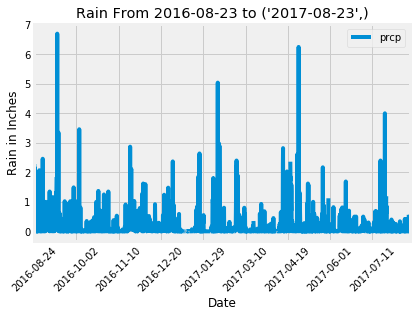

In [19]:
prcp_data.plot('date', 'prcp')
plt.xlabel('Date')
plt.ylabel('Rain in Inches')
plt.title(f'Rain From {prcp_last_record} to {prcp_recent_record}')
plt.xticks(rotation=45)
plt.savefig("Rain Data")

In [ ]:
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [22]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [23]:
station_obs = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).distinct().\
        order_by(func.count(Measurement.station).desc()).all()
station_obs


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
for x, y in station_obs:

    print(f"The station {x} had a total of {y} observations.")


The station USC00519281 had a total of 2772 observations.
The station USC00519397 had a total of 2724 observations.
The station USC00513117 had a total of 2709 observations.
The station USC00519523 had a total of 2669 observations.
The station USC00516128 had a total of 2612 observations.
The station USC00514830 had a total of 2202 observations.
The station USC00511918 had a total of 1979 observations.
The station USC00517948 had a total of 1372 observations.
The station USC00518838 had a total of 511 observations.


In [25]:
busy_station= station_obs[0][0]
busy_obs = station_obs[0][1]

print(f"The station {busy_station} had the most observations, {busy_obs} to be exact.")


The station USC00519281 had the most observations, 2772 to be exact.


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

max_temp = session.query(func.max(Measurement.tobs)).\
filter(Measurement.station == busy_station).\
filter(Measurement.date > prcp_last_record).all()\


min_temp = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == busy_station).\
filter(Measurement.date > prcp_last_record).all()\

avg_temp = session.query(func.avg(Measurement.tobs)).\
filter(Measurement.station == busy_station).\
filter(Measurement.date > prcp_last_record).all()\

print(max_temp, min_temp, avg_temp)

[(83.0,)] [(59.0,)] [(73.0968660968661,)]


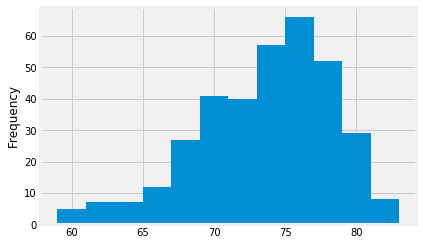

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
busy_temps = session.query(Measurement.tobs, Measurement.date, Measurement.station).\
filter(Measurement.station == busy_station).\
filter(Measurement.date > prcp_last_record).all()

busy_df = pd.DataFrame(busy_temps)

plt.hist(busy_df['tobs'],12)
plt.ylabel("Frequency")
plt.savefig("Temperature")

![precipitation](Images/station-histogram.png)

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates. 2017-03-01 2017-03-11

trip_temp = calc_temps('2017-03-01', '2017-03-11')
print(trip_temp)

[(62.0, 70.80597014925372, 82.0)]


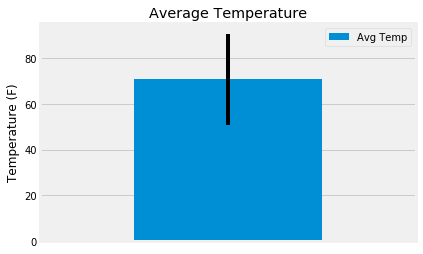

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
for z in trip_temp:
    min_temp = z[0]
    avg_temp = z[1]
    max_temp = z[2]
    
trip = {"Min Temp": [min_temp],
               "Avg Temp": [avg_temp],
               "Max Temp": [max_temp]}
trip_df = pd.DataFrame(trip)
trip_df
trip_df.plot.bar(y='Avg Temp',yerr=(max_temp - min_temp))
plt.xticks([], [])
plt.ylabel("Temperature (F)")
plt.title("Average Temperature")
plt.savefig("Temperature Histogram")

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_prcp(start_date, end_date):

    return session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude).\
        group_by(Measurement.station).distinct().order_by(func.sum(Measurement.prcp).desc()).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_prcp('2012-02-28', '2012-03-05'))

trip_prcp = calc_prcp('2012-02-28', '2012-03-05')

for p in trip_prcp:
    print(p)

('USC00519281', 11.08, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998)
('USC00516128', 10.32, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025)
('USC00513117', 5.79, 'KANEOHE 838.1, HI US', 21.4234, -157.8015)
('USC00518838', 3.8400000000000003, 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111)
('USC00519523', 2.92, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139)
('USC00519397', 1.1800000000000002, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168)
('USC00511918', 0.76, 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992)
('USC00514830', 0.03, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374)
('USC00517948', 0.0, 'PEARL CITY, HI US', 21.3934, -157.9751)


## Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

def normals (start_date, end_date):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query((func.strftime("%m-%d", Measurement.date)), *sel)\
            .group_by(func.strftime("%m-%d", Measurement.date))\
            .filter(func.strftime("%m-%d", Measurement.date) >= start_date).\
            filter(func.strftime("%m-%d", Measurement.date) <= end_date).all()

weather = normals('02-28', '03-05')
                                                          
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dates = []
min_temps = []
avg_temps = []
max_temps = []
for d in weather:

    datex = d[0]
    min_tempx = d[1]
    avg_tempx = d[2]
    max_tempx = d[3]
    
    dates.append(datex)
    min_temps.append(min_tempx)
    avg_temps.append(avg_tempx)
    max_temps.append(max_tempx)

    
normal_dict = {"Date": dates,
                "Min Temps": min_temps,
               "Avg Temps": avg_temps,
               "Max Temps": max_temps}
normal_df = pd.DataFrame(normal_dict)
trip_temp_df = normal_df.set_index('Date')

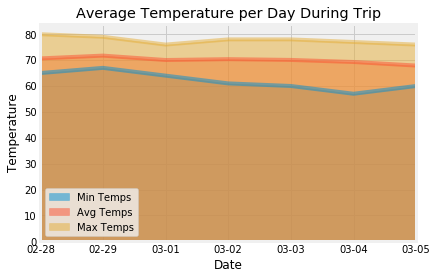

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temp_df.plot.area(stacked=False)
plt.ylabel("Temperature")
plt.title("Average Temperature per Day During Trip")
plt.savefig("Average Trip Temperatures")